## Visual Inspection of Motorcycle Connecting Rods
by Asif Khan Pattan
(asifkhan.pattan@studio.unibo.it)

In [1]:
# Importing all the required libraries

import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
import os

In [2]:
def threshold_image(image_path, task1=True):
    img = cv2.imread(image_path, 0)
    if not task1: # to remove noise for task 2
        img = cv2.medianBlur(img,3)
        img = cv2.medianBlur(img,3)
        img = cv2.medianBlur(img,3)
    _, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_OTSU)
    thresh = cv2.bitwise_not(thresh)
    return thresh

In [3]:
def get_connected_components(thresh):
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(thresh, connectivity=8, ltype=cv2.CV_32S)
    return num_labels, labels, stats

In [4]:
def calculate_angle(box):
    # Calculate the angle between two points of the rectangle
    distance1 = math.sqrt((box[1][0] - box[0][0])**2 + (box[1][1] - box[0][1])**2)
    distance2 = math.sqrt((box[2][0] - box[1][0])**2 + (box[2][1] - box[1][1])**2)

    if (distance1) < (distance2):
        angle = math.atan2(box[2][1] - box[1][1], box[2][0] - box[1][0]) * 180 / math.pi
        if angle < 0:
            angle = 180 + angle
    else:
        angle = math.atan2(box[1][1] - box[0][1], box[1][0] - box[0][0]) * 180 / math.pi
        if angle < 0:
            angle = 180 + angle
    return angle

In [5]:
def hole_inspection(contour, color_img):
    if len(contour) > 25:  
        (x, y), radius = cv2.minEnclosingCircle(contour)
        center = (int(x), int(y))
        radius = np.around(radius,2)
        print(f"Position of center of hole and diameter are {center} and {radius*2} ")
        cv2.circle(color_img, center, int(radius), (0, 0, 255))
    

In [6]:
def get_mask(labels, ref_label):
    mask = np.zeros_like(labels, dtype=np.uint8)
    mask[labels == ref_label] = 255
    return mask

In [7]:
def perform_inspection(image_path, task1=False):
    thresh = threshold_image(image_path, task1)
    if not task1: # only for task 3
        kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(2,2))
        thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
        thresh = cv2.dilate(thresh, kernel)
    num_labels, labels, _ = get_connected_components(thresh)

    for i in range(1, num_labels):
        mask = get_mask(labels, i)
        color_img = cv2.cvtColor(np.copy(mask), cv2.COLOR_GRAY2BGR)
        
        contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        if len(contours) == 2: # hole + main rod countor
            print('Rod {} is of type A'.format(i))
        else: 
            print('Rod {} is of type B'.format(i))

        largest_contour = max(contours, key=cv2.contourArea) # removing the main external counter of the rod
        contours = list(contours)
        largest_contour_index = contours.index(largest_contour)
        contours.pop(largest_contour_index)

        for contour in contours:
            hole_inspection(contour, color_img)
                
        # Get the minimum area bounding rectangle of the contour
        rect = cv2.minAreaRect(largest_contour)
        if rect[1][0] > rect[1][1]:
            height, width = rect[1]
        else:
            width, height = rect[1]


        # Get the four vertices of the rectangle
        box = cv2.boxPoints(rect)
        box = np.intp(box)

        # Draw the rotated rectangle on the output image
        cv2.drawContours(color_img, [box], 0, (0, 255, 0))

        angle = calculate_angle(box)

        # Calculate the center of Rod
        M = cv2.moments(largest_contour)
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        cv2.circle(color_img, (int(cX), int(cY)), 1, (0, 255, 0), -1)

        # Compute the distance transform of the binary image
        dist_transform = cv2.distanceTransform(mask, cv2.DIST_L2, 5)

        # Get the value of the distance transform at the barycenter
        radius_at_barycenter = dist_transform[cY, cX]

        # Calculate the width at the barycenter
        width_at_barycenter = 2 * radius_at_barycenter

        print(f"Rod {i} width at barycenter: {width_at_barycenter:.2f}")
        
        # Draw a circle at the barycenter with radius equal to width_at_barycenter / 2
        cv2.circle(color_img, (cX, cY), int(radius_at_barycenter), (255, 0, 0), 2)
        
        # Display information
        print(f"Rod {i} Angle: {(angle):.2f} degrees")
        print(f"Rod {i} Center: {(cX, cY)}")
        print(f"Rod {i} width, height: {width:.2f}, {height:.2f}")
        print(50 *"-")

        # Plot the output 
        plt.imshow(color_img)
        plt.show()

In [8]:
# Folder path and specific image list
folder_path = r'C:\\Users\\asifk\\Documents\\CV\\ispezione-bielle-immagini'
task_one = ['TESI00.BMP', 'TESI01.BMP', 'TESI12.BMP', 'TESI21.BMP', 'TESI31.BMP', 'TESI33.BMP']
task_two = ['TESI90.BMP', 'TESI92.BMP', 'TESI98.BMP']


Task 1


Processing image: C:\\Users\\asifk\\Documents\\CV\\ispezione-bielle-immagini\TESI00.BMP
Rod 1 is of type A
Position of center of hole and diameter are (179, 68) and 26.5 
Rod 1 width at barycenter: 15.18
Rod 1 Angle: 69.64 degrees
Rod 1 Center: (198, 113)
Rod 1 width, height: 39.78, 169.35
--------------------------------------------------


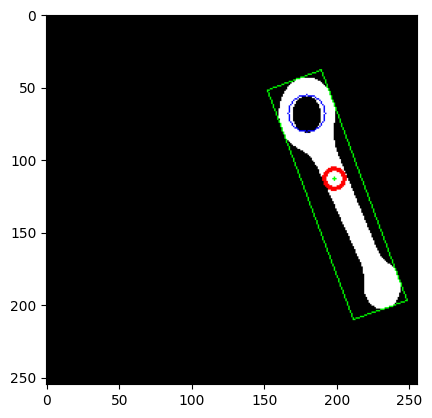

Rod 2 is of type B
Position of center of hole and diameter are (109, 159) and 28.86 
Position of center of hole and diameter are (121, 60) and 25.2 
Rod 2 width at barycenter: 14.79
Rod 2 Angle: 95.23 degrees
Rod 2 Center: (115, 115)
Rod 2 width, height: 26.98, 131.73
--------------------------------------------------


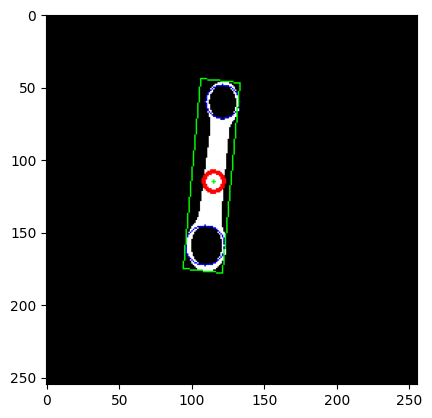

Rod 3 is of type A
Position of center of hole and diameter are (51, 200) and 26.68 
Rod 3 width at barycenter: 16.00
Rod 3 Angle: 90.97 degrees
Rod 3 Center: (54, 148)
Rod 3 width, height: 38.09, 177.19
--------------------------------------------------


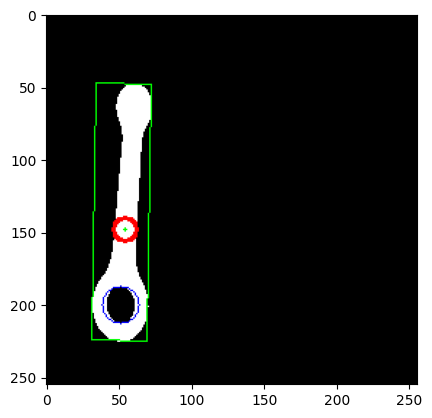

Processing image: C:\\Users\\asifk\\Documents\\CV\\ispezione-bielle-immagini\TESI01.BMP
Rod 1 is of type A
Position of center of hole and diameter are (179, 68) and 26.5 
Rod 1 width at barycenter: 15.18
Rod 1 Angle: 69.52 degrees
Rod 1 Center: (198, 113)
Rod 1 width, height: 39.88, 169.00
--------------------------------------------------


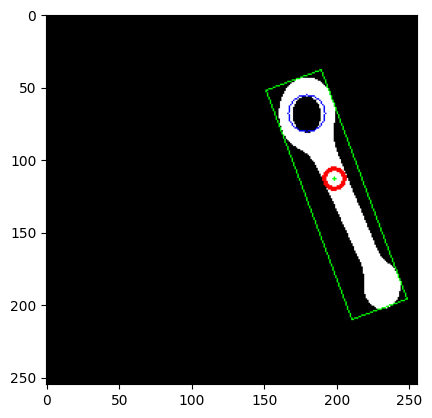

Rod 2 is of type B
Position of center of hole and diameter are (109, 159) and 28.86 
Position of center of hole and diameter are (121, 60) and 25.2 
Rod 2 width at barycenter: 12.79
Rod 2 Angle: 95.23 degrees
Rod 2 Center: (114, 115)
Rod 2 width, height: 26.99, 131.73
--------------------------------------------------


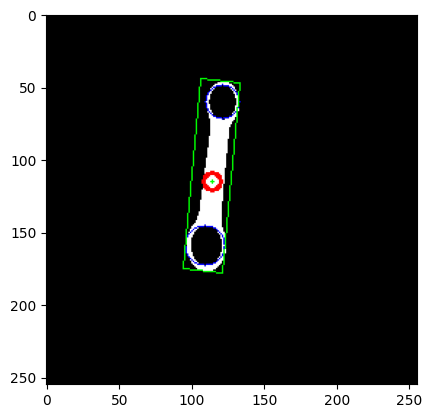

Rod 3 is of type A
Position of center of hole and diameter are (51, 200) and 26.68 
Rod 3 width at barycenter: 16.00
Rod 3 Angle: 91.29 degrees
Rod 3 Center: (54, 148)
Rod 3 width, height: 37.27, 177.26
--------------------------------------------------


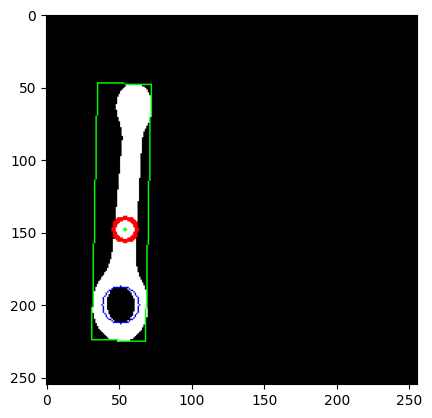

Processing image: C:\\Users\\asifk\\Documents\\CV\\ispezione-bielle-immagini\TESI12.BMP
Rod 1 is of type A
Position of center of hole and diameter are (45, 115) and 27.3 
Rod 1 width at barycenter: 16.80
Rod 1 Angle: 134.73 degrees
Rod 1 Center: (78, 85)
Rod 1 width, height: 43.81, 152.07
--------------------------------------------------


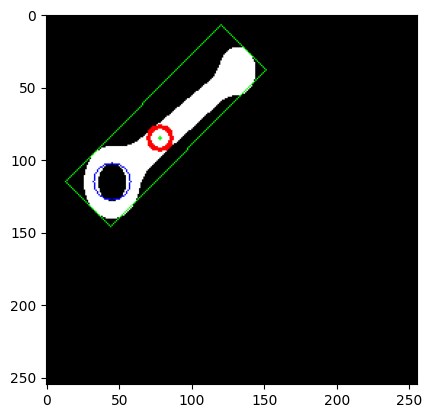

Rod 2 is of type B
Position of center of hole and diameter are (87, 119) and 25.4 
Position of center of hole and diameter are (163, 114) and 29.3 
Rod 2 width at barycenter: 18.00
Rod 2 Angle: 178.85 degrees
Rod 2 Center: (129, 116)
Rod 2 width, height: 35.09, 100.13
--------------------------------------------------


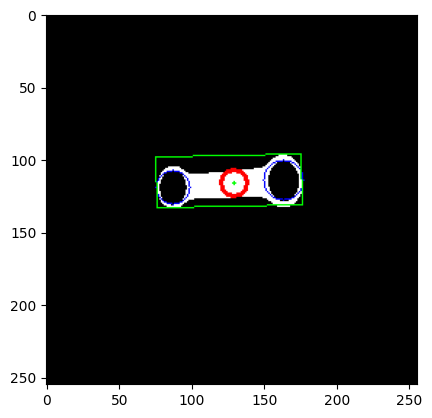

Rod 3 is of type A
Position of center of hole and diameter are (149, 167) and 27.46 
Rod 3 width at barycenter: 19.18
Rod 3 Angle: 0.00 degrees
Rod 3 Center: (109, 171)
Rod 3 width, height: 50.00, 136.00
--------------------------------------------------


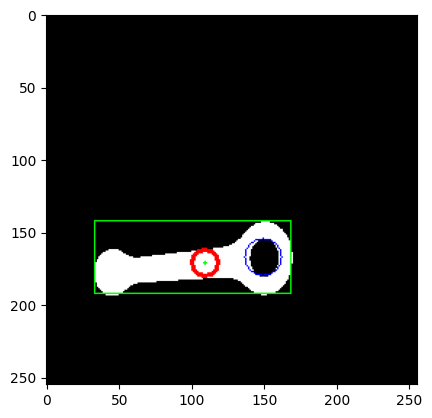

Processing image: C:\\Users\\asifk\\Documents\\CV\\ispezione-bielle-immagini\TESI21.BMP
Rod 1 is of type B
Position of center of hole and diameter are (84, 149) and 31.6 
Position of center of hole and diameter are (138, 45) and 33.78 
Rod 1 width at barycenter: 18.78
Rod 1 Angle: 116.57 degrees
Rod 1 Center: (114, 91)
Rod 1 width, height: 37.12, 156.52
--------------------------------------------------


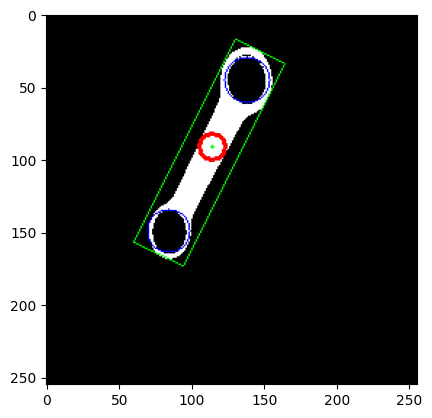

Rod 2 is of type A
Position of center of hole and diameter are (200, 119) and 34.24 
Rod 2 width at barycenter: 21.19
Rod 2 Angle: 134.37 degrees
Rod 2 Center: (158, 157)
Rod 2 width, height: 55.80, 193.12
--------------------------------------------------


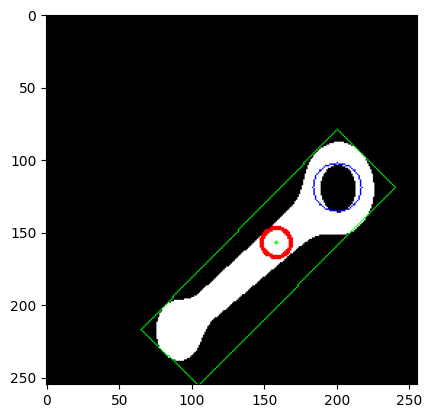

Processing image: C:\\Users\\asifk\\Documents\\CV\\ispezione-bielle-immagini\TESI31.BMP
Rod 1 is of type A
Position of center of hole and diameter are (224, 83) and 33.44 
Rod 1 width at barycenter: 20.38
Rod 1 Angle: 117.55 degrees
Rod 1 Center: (193, 136)
Rod 1 width, height: 52.11, 208.07
--------------------------------------------------


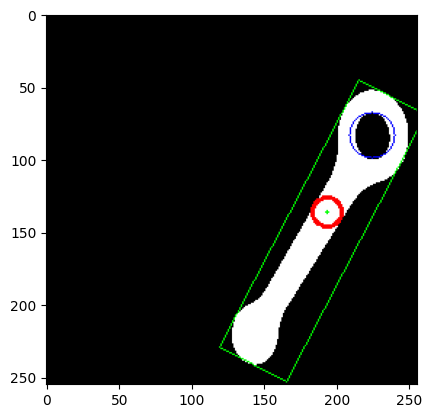

Rod 2 is of type B
Position of center of hole and diameter are (33, 163) and 31.42 
Position of center of hole and diameter are (129, 158) and 36.34 
Rod 2 width at barycenter: 24.00
Rod 2 Angle: 0.00 degrees
Rod 2 Center: (87, 160)
Rod 2 width, height: 46.00, 127.00
--------------------------------------------------


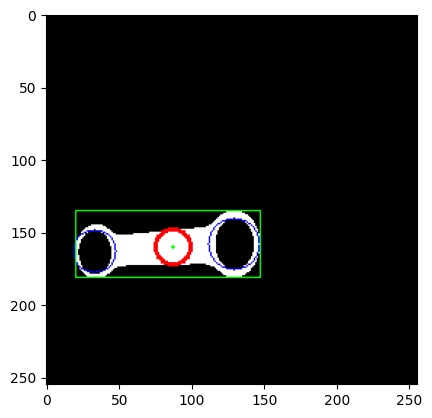

Processing image: C:\\Users\\asifk\\Documents\\CV\\ispezione-bielle-immagini\TESI33.BMP
Rod 1 is of type A
Position of center of hole and diameter are (150, 61) and 33.3 
Rod 1 width at barycenter: 22.40
Rod 1 Angle: 132.10 degrees
Rod 1 Center: (108, 101)
Rod 1 width, height: 55.56, 194.87
--------------------------------------------------


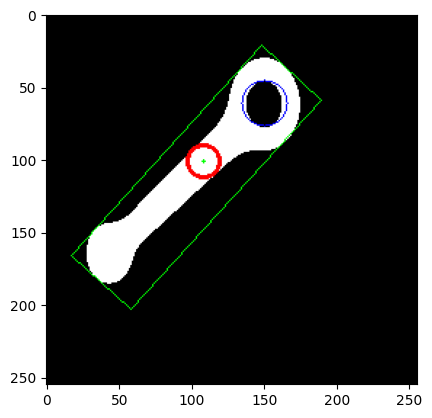

Rod 2 is of type A
Position of center of hole and diameter are (104, 180) and 33.74 
Rod 2 width at barycenter: 22.79
Rod 2 Angle: 141.05 degrees
Rod 2 Center: (149, 149)
Rod 2 width, height: 58.52, 187.25
--------------------------------------------------


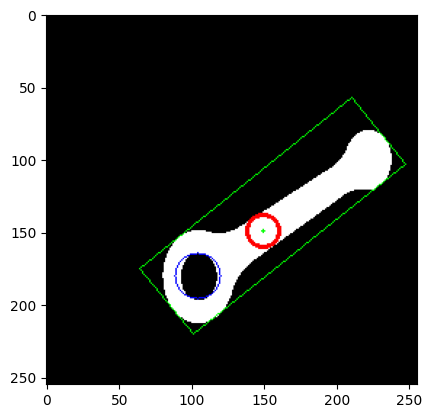

In [9]:
image_paths = [os.path.join(folder_path, img) for img in task_one]

is_task1 = True # True when task_one inspection has to be performed
# Process the specified images
for path in image_paths:
    print(f"Processing image: {path}")
    perform_inspection(path, task1= is_task1)

Task 2 (challenge three)

Processing image: C:\\Users\\asifk\\Documents\\CV\\ispezione-bielle-immagini\TESI90.BMP
Rod 1 is of type A
Position of center of hole and diameter are (122, 76) and 27.74 
Rod 1 width at barycenter: 21.19
Rod 1 Angle: 48.11 degrees
Rod 1 Center: (157, 109)
Rod 1 width, height: 49.26, 168.82
--------------------------------------------------


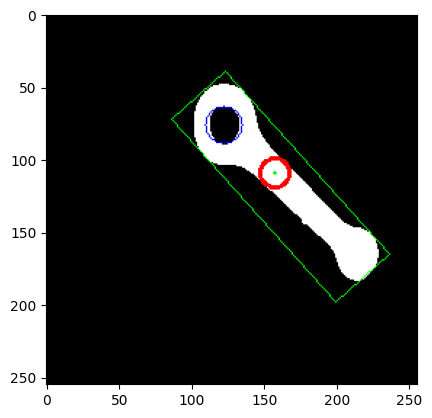

Rod 2 is of type B
Position of center of hole and diameter are (114, 186) and 26.48 
Position of center of hole and diameter are (54, 111) and 30.14 
Rod 2 width at barycenter: 18.78
Rod 2 Angle: 53.22 degrees
Rod 2 Center: (82, 144)
Rod 2 width, height: 35.18, 128.81
--------------------------------------------------


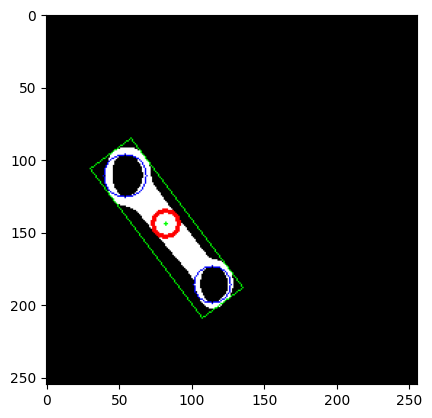

Processing image: C:\\Users\\asifk\\Documents\\CV\\ispezione-bielle-immagini\TESI92.BMP
Rod 1 is of type A
Position of center of hole and diameter are (31, 149) and 28.3 
Rod 1 width at barycenter: 18.78
Rod 1 Angle: 118.56 degrees
Rod 1 Center: (59, 105)
Rod 1 width, height: 45.72, 179.98
--------------------------------------------------


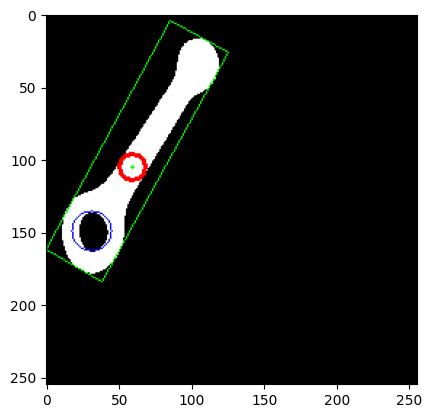

Rod 2 is of type B
Position of center of hole and diameter are (146, 115) and 26.56 
Position of center of hole and diameter are (227, 107) and 29.86 
Rod 2 width at barycenter: 20.00
Rod 2 Angle: 176.36 degrees
Rod 2 Center: (191, 110)
Rod 2 width, height: 39.36, 110.85
--------------------------------------------------


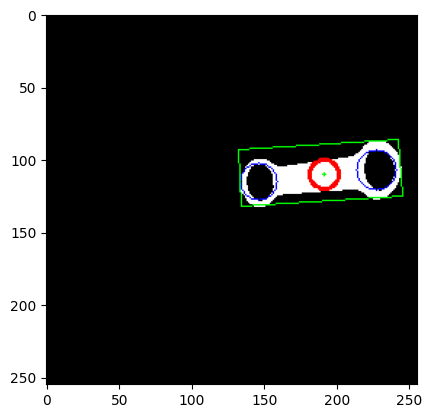

Rod 3 is of type A
Position of center of hole and diameter are (206, 177) and 28.28 
Rod 3 width at barycenter: 22.00
Rod 3 Angle: 0.00 degrees
Rod 3 Center: (163, 173)
Rod 3 width, height: 55.00, 148.00
--------------------------------------------------


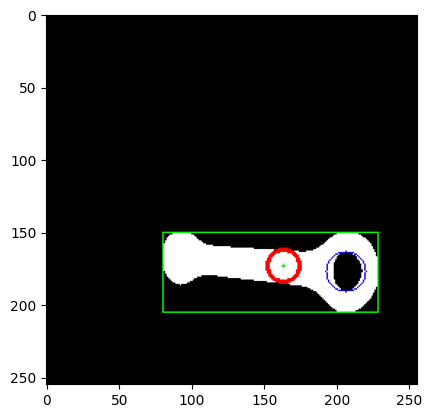

Processing image: C:\\Users\\asifk\\Documents\\CV\\ispezione-bielle-immagini\TESI98.BMP
Rod 1 is of type A
Position of center of hole and diameter are (209, 75) and 27.66 
Rod 1 width at barycenter: 17.19
Rod 1 Angle: 115.30 degrees
Rod 1 Center: (183, 122)
Rod 1 width, height: 45.02, 182.56
--------------------------------------------------


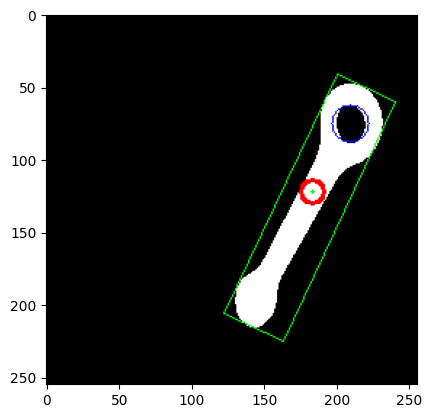

Rod 2 is of type B
Position of center of hole and diameter are (111, 151) and 30.26 
Position of center of hole and diameter are (35, 107) and 25.74 
Rod 2 width at barycenter: 20.38
Rod 2 Angle: 32.47 degrees
Rod 2 Center: (77, 131)
Rod 2 width, height: 38.41, 117.81
--------------------------------------------------


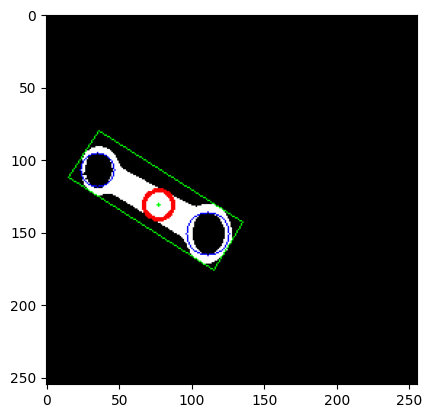

In [10]:
image_paths = [os.path.join(folder_path, img) for img in task_two]

is_task1 = False # True when task_one inspection has to be performed
# Process the specified images
for path in image_paths:
    print(f"Processing image: {path}")
    perform_inspection(path, task1= is_task1)